In [1]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

/Users/stanislavprihoda/anaconda3/envs/fastai/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/stanislavprihoda/anaconda3/envs/fastai/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/stanislavprihoda/anaconda3/envs/fastai/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Initial setup

#### Data

In [2]:
mpl.rcParams['image.cmap']='gray'

In [3]:
x_trn,y_trn,x_val,y_val=get_data()

In [4]:
n,m=x_trn.shape
c=y_trn.max()+1
nh=50

In [6]:
class Model(nn.Module):
    def __init__(self,n_in,nh,n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh),nn.ReLU(),nn.Linear(nh,n_out)]
    def __call__(self,x):
        for l in self.layers:x=l(x)
        return x

In [7]:
model = Model(m,nh,10)

In [8]:
pred=model(x_trn)

### Crossentropy loss

In [9]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [10]:
sm_pred = log_softmax(pred)

In [11]:
sm_pred

tensor([[-2.5352, -2.3762, -2.1422,  ..., -2.3006, -2.1026, -2.2347],
        [-2.5055, -2.3965, -2.2156,  ..., -2.3553, -2.1166, -2.1940],
        [-2.3644, -2.3458, -2.2401,  ..., -2.3585, -2.2067, -2.3744],
        ...,
        [-2.4796, -2.1916, -2.2970,  ..., -2.3619, -2.2456, -2.2060],
        [-2.4294, -2.3237, -2.2744,  ..., -2.3576, -2.1969, -2.2106],
        [-2.5134, -2.2212, -2.3540,  ..., -2.3636, -2.2202, -2.2302]],
       grad_fn=<LogBackward>)

In [13]:
y_trn.shape

torch.Size([50000])

In [14]:
y_trn[:3]

tensor([5, 0, 4])

In [15]:
sm_pred[[0,1,2],[5,0,4]]

tensor([-2.2669, -2.5055, -2.1370], grad_fn=<IndexBackward>)

In [23]:
def nll(inp, target): return -inp[range(target.shape[0]),target].mean()

In [24]:
loss=nll(sm_pred,y_trn)

In [26]:
loss

tensor(2.3181, grad_fn=<NegBackward>)

In [27]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [28]:
test_near(nll(log_softmax(pred),y_trn),loss)

In [29]:
def logsumexp(x):
    m=x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [31]:
test_near(logsumexp(pred),pred.logsumexp(-1))

In [32]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [33]:
test_near(nll(log_softmax(pred),y_trn),loss)

In [35]:
test_near(F.nll_loss(F.log_softmax(pred,-1),y_trn),loss)

In [36]:
test_near(F.cross_entropy(pred,y_trn),loss)

### Basic training loop

In [37]:
loss_func = F.cross_entropy

In [38]:
#export
def accuracy(out,yb): return (torch.argmax(out,dim=1)==yb).float().mean()

In [40]:
bs=64 #batchsize

xb=x_trn[0:bs] #first mini-batch
preds=model(xb)
preds[0],preds.shape

(tensor([-0.2730, -0.1141,  0.1200, -0.1821, -0.0651, -0.0047, -0.1118, -0.0384,
          0.1596,  0.0275], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [42]:
loss_func(preds,y_trn[0:64])

tensor(2.3223, grad_fn=<NllLossBackward>)

In [44]:
accuracy(preds,y_trn[0:64])

tensor(0.1094)

In [45]:
lr=0.5 #learning rate
epochs=1

In [59]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        # set_trace()
        start_i = i*bs
        end_i = start_i+bs
        xb=x_trn[start_i:end_i]
        yb=y_trn[start_i:end_i]
        loss=loss_func(model(xb),yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l,'weight'):
                    l.weight -= l.weight.grad*lr
                    l.bias -= l.bias.grad*lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [60]:
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.0023, grad_fn=<NllLossBackward>), tensor(1.))

#### using parameters and optim

In [61]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [64]:
mdl = DummyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [65]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

In [72]:
class Model(nn.Module):
    def __init__(self,n_in,nh,n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self,x): return self.l2(F.relu(self.l1(x)))

In [73]:
model = Model(m,nh,10)

In [74]:
for name,l in model.named_children(): print(f"{name}:{l}")

l1:Linear(in_features=784, out_features=50, bias=True)
l2:Linear(in_features=50, out_features=10, bias=True)


In [75]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [76]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            # set_trace()
            start_i = i*bs
            end_i = start_i+bs
            xb=x_trn[start_i:end_i]
            yb=y_trn[start_i:end_i]
            loss=loss_func(model(xb),yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p-=p.grad*lr
                model.zero_grad()

In [80]:
fit()
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.0071, grad_fn=<NllLossBackward>), tensor(1.))

#### registering modules

In [81]:
layers=[nn.Linear(m,nh),nn.ReLU(),nn.Linear(nh,10)]

In [82]:
class Model(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers=layers
        for i,l in enumerate(self.layers): self.add_module(f"layer_{i}",l)
    def __call__(self,x):
        for l in self.layers: x=l(x)
        return x

In [83]:
model = Model(layers)

In [84]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

#### nn.ModuleList

In [85]:
class SequentialModel(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    def __call__(self,x):
        for l in self.layers: x=l(x)
        return x

In [86]:
model = SequentialModel(layers)

In [87]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

#### nn.Sequential

In [88]:
model = nn.Sequential(nn.Linear(m,nh),nn.ReLU(),nn.Linear(nh,10))

In [93]:
fit()
loss_func(model(xb),yb),accuracy(model(xb),yb)

(tensor(0.0238, grad_fn=<NllLossBackward>), tensor(1.))

In [94]:
nn.Sequential??

#### optimizer

In [95]:
class Optimizer():
    def __init__(self,params,lr=0.5):
        self.params,self.lr = list(params),lr
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad*lr
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [97]:
model = nn.Sequential(nn.Linear(m,nh),nn.ReLU(),nn.Linear(nh,10))

In [98]:
opt = Optimizer(model.parameters())

In [104]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb=x_trn[start_i:end_i]
        yb=y_trn[start_i:end_i]
        pred=model(xb)
        loss=loss_func(pred,yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [105]:
loss,acc = loss_func(model(xb),yb),accuracy(model(xb),yb)
loss,acc

(tensor(0.0058, grad_fn=<NllLossBackward>), tensor(1.))

In [123]:
#export
from torch import optim

In [132]:
optim.SGD.step??

In [136]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh),nn.ReLU(),nn.Linear(nh,10))
    opt = optim.SGD(model.parameters(),lr=lr)
    return model,opt

In [137]:
model,opt = get_model()

In [126]:
loss_func(model(xb),yb)

tensor(2.2768, grad_fn=<NllLossBackward>)

In [127]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb=x_trn[start_i:end_i]
        yb=y_trn[start_i:end_i]
        pred=model(xb)
        loss=loss_func(pred,yb)
        
        loss.backward() 
        opt.step()
        opt.zero_grad()

In [128]:
loss,acc=loss_func(model(xb),yb),accuracy(model(xb),yb)

In [129]:
loss,acc

(tensor(0.0728, grad_fn=<NllLossBackward>), tensor(0.9375))

In [130]:
assert acc>0.7

### Dataset and DataLoader

#### Dataset

In [133]:
#export
class Dataset():
    def __init__(self,x,y): self.x,self.y=x,y
    def __len__(self): return len(self.x)
    def __getitem__(self,i): return self.x[i],self.y[i]

In [134]:
train_ds,valid_ds = Dataset(x_trn,y_trn),Dataset(x_val,y_val)
assert len(train_ds)==len(x_trn)
assert len(valid_ds)==len(x_val)

In [135]:
xb,yb=train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [138]:
model,opt = get_model()

In [147]:
for epoch in range(epochs):
    for i in range((n-1)//bs+1):
        xb,yb = train_ds[i*bs:i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred,yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [148]:
loss,acc=loss_func(model(xb),yb),accuracy(model(xb),yb)
assert acc>0.7
loss,acc

(tensor(0.0053, grad_fn=<NllLossBackward>), tensor(1.))

#### Dataloader 

In [156]:
class DataLoader():
    def __init__(self,ds,bs): self.ds, self.bs = ds,bs
    def __iter__(self):
        for i in range(0,len(self.ds),self.bs): yield self.ds[i:i+self.bs]

In [157]:
train_dl = DataLoader(train_ds,bs)
valid_dl = DataLoader(valid_ds,bs)

In [158]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(bs,28*28)
assert yb.shape==(bs,)

tensor(3)

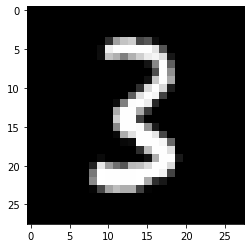

In [159]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [166]:
model,opt = get_model()

In [167]:
epochs=3

In [168]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred,yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [169]:
fit()

In [170]:
loss,acc = loss_func(model(xb),yb),accuracy(model(xb),yb)
assert acc>0.7
loss,acc

(tensor(0.0151, grad_fn=<NllLossBackward>), tensor(1.))

#### Random sampling

In [171]:
class Sampler():
    def __init__(self,ds,bs,shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
    
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0,self.n,self.bs): yield self.idxs[i:i+self.bs]

In [172]:
small_ds = Dataset(*train_ds[:10])

In [176]:
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [177]:
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([4, 9, 6]), tensor([8, 3, 2]), tensor([7, 0, 1]), tensor([5])]

In [179]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

class DataLoader():
    def __init__(self,ds,sampler,collate_fn=collate):
        self.ds,self.sampler,self.collate_fn=ds,sampler,collate_fn
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [180]:
train_samp = Sampler(train_ds,bs,shuffle=True)
valid_samp = Sampler(valid_ds,bs,shuffle=False)

In [181]:
train_dl = DataLoader(train_ds,sampler=train_samp,collate_fn=collate)
valid_dl = DataLoader(valid_ds,sampler=valid_samp,collate_fn=collate)

tensor(6)

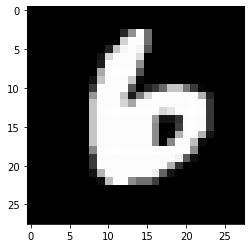

In [187]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(5)

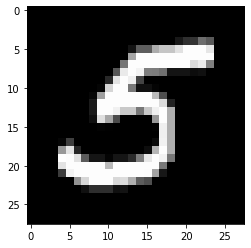

In [188]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [189]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb),yb),accuracy(model(xb),yb)
assert acc>0.7
loss,acc

(tensor(0.1670, grad_fn=<NllLossBackward>), tensor(0.9688))

#### Pytorch DataLoader 

In [190]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [191]:
train_dl = DataLoader(train_ds,bs,sampler=RandomSampler(train_ds),collate_fn=collate)
val_dl = DataLoader(valid_ds,bs,sampler=SequentialSampler(valid_ds),collate_fn=collate)


In [192]:
model,opt=get_model()
fit()
loss_func(model(xb),yb), accuracy(model(xb),yb)

(tensor(0.0819, grad_fn=<NllLossBackward>), tensor(0.9688))

In [193]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [194]:
model,opt=get_model()
fit()
loss_func(model(xb),yb), accuracy(model(xb),yb)

(tensor(0.1208, grad_fn=<NllLossBackward>), tensor(0.9688))

### Validation

In [202]:
def fit(epochs, model, locc_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        #handle batch norm droput
        model.train()
        #print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb),yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        #print(model.training)
        with torch.no_grad():
            tot_loss, tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred,yb)
                tot_acc += accuracy(pred, yb)
        nv = len(valid_dl)
        print(epoch,tot_loss/nv,tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [205]:
#export 
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, bs, shuffle=True, drop_last=True, **kwargs),
           DataLoader(valid_ds, bs*2, shuffle=False, **kwargs))

In [206]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.1919) tensor(0.9400)
1 tensor(0.1209) tensor(0.9633)
2 tensor(0.1067) tensor(0.9691)
3 tensor(0.1060) tensor(0.9681)
4 tensor(0.0970) tensor(0.9710)


### Export

In [3]:
!python3 notebook2script.py 03_Minibatch-training.ipynb

Converted 03_Minibatch-training.ipynb to exp/nb_03.py
